# Group Analysis - FOOOFed EEG Analysis

In [1]:
%config InlineBackend.figure_format='retina'

%matplotlib inline
%load_ext autoreload

In [2]:
from os import listdir
from os.path import join as pjoin

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from scipy.stats import ttest_ind, sem, pearsonr

from fooof import FOOOFGroup
from fooof.analysis import get_band_peak_group
from fooof.core.funcs import gaussian_function
from fooof.core.funcs import expo_nk_function

from om.core.utils import clean_file_list

In [3]:
# Import custom code for this analysis
% autoreload 2
from plts import *
from utils import *

### Settings

In [4]:
# Set which group to run
group = 'G2'

# Set path to load results from
res_path = pjoin('/Users/tom/Documents/Research/1-Projects/fooof/2-Data/Results/', group)

# Data settings
srate = 512
tmin, tmax = -0.85, 1.1
n_times = 3
n_loads = 3
n_subjs = 31

# Set indices to separate groups
yng_inds = range(14, 31)
old_inds = range(0, 14)

# Set average function to use
avg_func = np.nanmean
#avg_func = np.nanmedian

print('Number of young subjects:  ', len(yng_inds))
print('Number of  old  subjects:  ', len(old_inds))

Number of young subjects:   17
Number of  old  subjects:   14


## Behavioural Data

In [5]:
# Load behavioural Data
behav_file = pjoin(res_path, 'Behav', 'neural_aging_data_behaviour.csv')
behav_dat = pd.read_csv(behav_file)

In [6]:
# Sanity check behavioural data
behav_dat.head()

,SubjID,Age,Load,CDA,d'
0,1,1,1,-0.442318,4.701454
1,2,1,1,-0.326298,3.934543
2,3,1,1,-1.291108,3.040111
3,4,1,1,-1.692917,4.733815
4,5,1,1,-0.173045,4.380097


In [7]:
# Collapse behavioural data across loads
avg_behav = behav_dat.groupby('SubjID').mean()

In [8]:
# Check correlations between d' and CDA measure
print_stat('All: \t', *pearsonr(avg_behav["CDA"], avg_behav["d'"]))
print_stat('Yng: \t', *pearsonr(avg_behav[avg_behav['Age'] == 1]["CDA"], avg_behav[avg_behav['Age'] == 1]["d'"]))
print_stat('Old: \t', *pearsonr(avg_behav[avg_behav['Age'] == 2]["CDA"], avg_behav[avg_behav['Age'] == 2]["d'"]))

All: 	: 	  0.0104 	0.9555
Yng: 	: 	  0.2805 	0.2755
Old: 	: 	 -0.4481 	0.1081


### Alpha Peak Frequency

In [9]:
# Load alpha peaks
#alpha_freqs = np.load(pjoin(res_path, 'Group', 'alpha_freqs_group.npy'))

# Check average alpha frequency per group
#print(avg_func(alpha_freqs[yng_inds]))
#print(avg_func(alpha_freqs[old_inds]))

### Check dropped trials

In [10]:
# Load dropped trials & components
dropped_trials = np.load(pjoin(res_path, 'Group', 'dropped_trials.npy'))
dropped_components = np.load(pjoin(res_path, 'Group', 'dropped_components.npy'))

# Check dropped trials for each subject
print('SubNum \t\t # Dropped Trials \t # Dropped Components')
for ind, trials, components in zip(range(n_subjs), dropped_trials, dropped_components):
    temp_trials = trials[np.nonzero(trials)]
    temp_comps = components[np.nonzero(components)]
    print(ind, '\t\t', len(temp_trials), '\t\t\t', len(temp_comps))

SubNum 		 # Dropped Trials 	 # Dropped Components
0 		 5 			 3
1 		 15 			 4
2 		 1 			 0
3 		 13 			 1
4 		 18 			 2
5 		 0 			 7
6 		 28 			 6
7 		 7 			 0
8 		 29 			 4
9 		 4 			 4
10 		 2 			 3
11 		 0 			 4
12 		 14 			 7
13 		 2 			 2
14 		 2 			 3
15 		 0 			 5
16 		 3 			 3
17 		 11 			 0
18 		 2 			 2
19 		 109 			 3
20 		 38 			 6
21 		 14 			 4
22 		 0 			 2
23 		 0 			 4
24 		 1 			 3
25 		 15 			 0
26 		 4 			 3
27 		 12 			 4
28 		 41 			 4
29 		 34 			 5
30 		 0 			 3


### Task Related - Filtered Alpha Response

In [11]:
# Load data
canonical_group = np.load(pjoin(res_path, 'Group', 'canonical_group.npy'))
fooofed_group = np.load(pjoin(res_path, 'Group', 'fooofed_group.npy'))

In [12]:
# Partition group
subset = 'young' # 'young', 'old', 'all'
if subset == 'old':
    canonical_group = canonical_group[0:15, :, :]
    fooofed_group = fooofed_group[0:15, :, :]
if subset == 'young':
    canonical_group = canonical_group[15:, :, :]
    fooofed_group = fooofed_group[15:, :, :]
if subset == 'all':
    canonical_group = canonical_group
    fooofed_group = fooofed_group

In [13]:
# Average across subjects
canonical_group_avg = avg_func(canonical_group, 0)
fooofed_group_avg = avg_func(fooofed_group, 0)

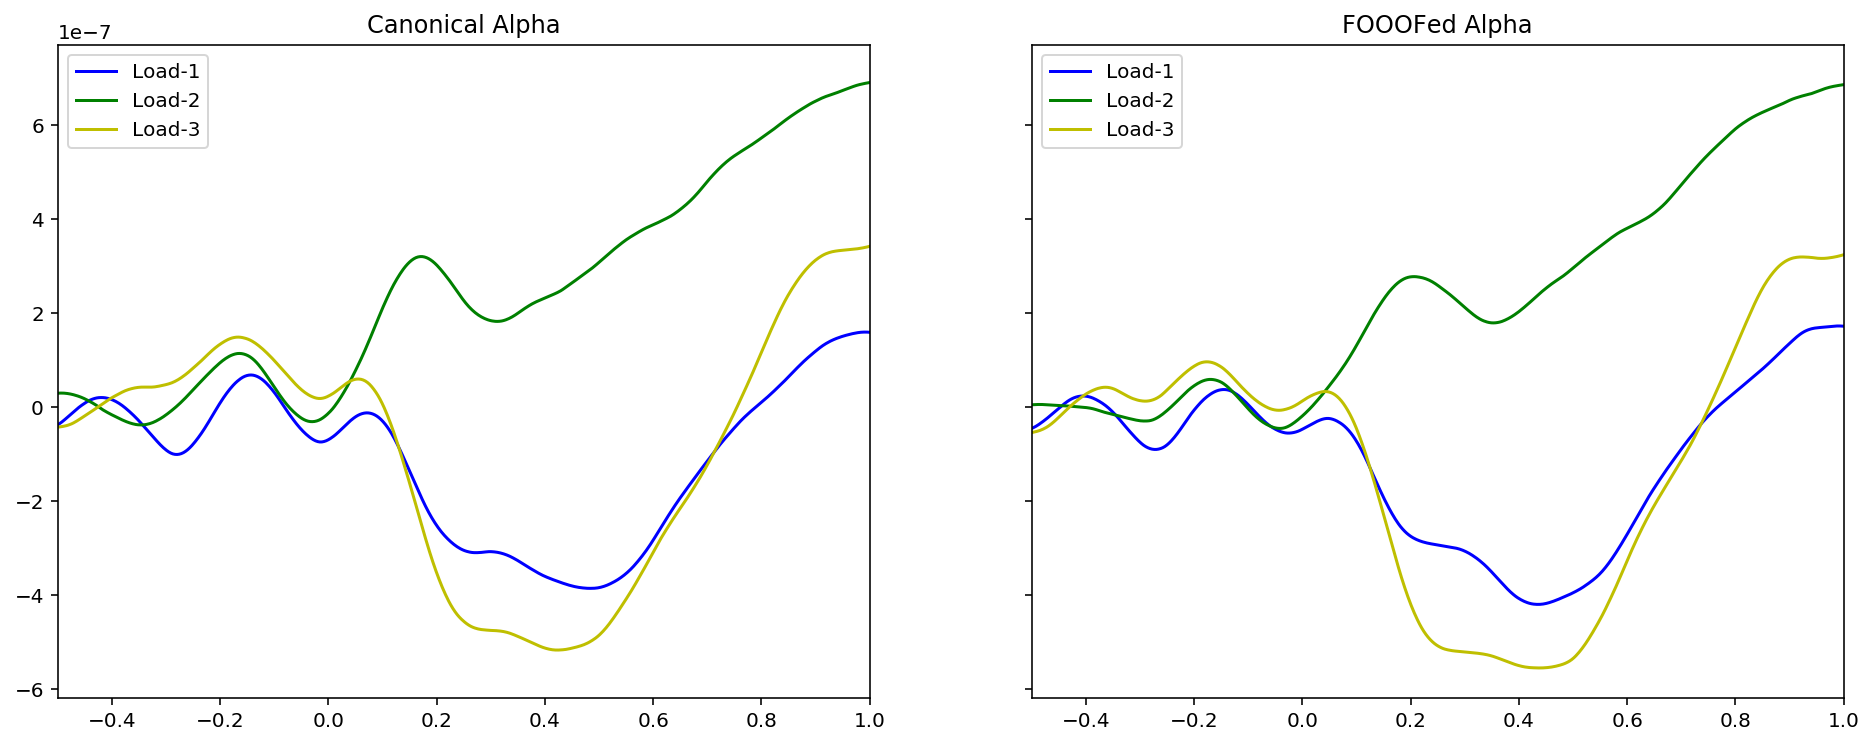

In [14]:
# Plot the alpha response - group average
plot_alpha_response_compare(canonical_group_avg, fooofed_group_avg, [tmin, tmax], srate)

In [15]:
# Plot each individual subject
#for alpha_subj, fooof_subj in zip(canonical_group, fooofed_group):
#    plot_alpha_response_compare(alpha_subj, fooof_subj, [tmin, tmax], srate)

In [16]:
# Grab the time that represent the late time period: 0.8 - 1.0
times = np.arange(tmin, tmax, 1/srate)
late_times = np.array(times >= 0.8) & np.array(times <= 1.0)

In [17]:
# Extract late time period, and average across it
#canonical_group_late = np.mean(canonical_group[:, :, late_times], 2)
#fooofed_group_late = np.mean(fooofed_group[:, :, late_times], 2)

canonical_group_late = np.median(canonical_group[:, :, late_times], 2)
fooofed_group_late = np.median(fooofed_group[:, :, late_times], 2)

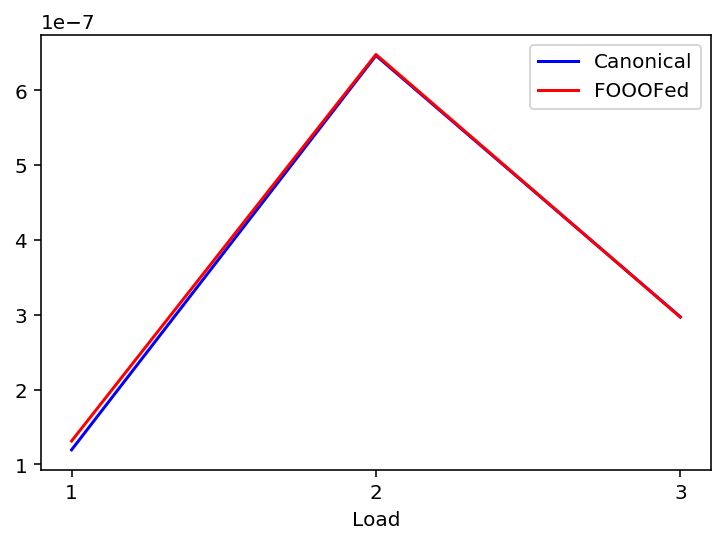

In [18]:
# Plot group average alpha power, per load, in late window, for canonical & fooofed bands
plt.figure()
plt.plot(avg_func(canonical_group_late, 0), 'b', label='Canonical')
plt.plot(avg_func(fooofed_group_late, 0), 'r', label='FOOOFed')
plt.xticks([0, 1, 2], [1, 2, 3]);
plt.xlabel('Load')
plt.legend();

## FOOOF

In [19]:
# Settings
save_fig = True

In [20]:
# Get list of all FOOOF files
files = listdir(pjoin(res_path, 'FOOOF'))

# Select group files
files = clean_file_list(files, 'RAW')

#Check file names
#print(files)

In [21]:
# Load all subject FOOOFGroups
fg = FOOOFGroup()
fgs = []
for file in files:
    fg.load(file, pjoin(res_path, 'FOOOF'))
    fgs.append(fg.copy())

In [22]:
# Grab alphas from each subject
ch_ind = 28  # 28 is Oz
alphas = np.empty(shape=[len(fgs), 3])
for ind, fg in enumerate(fgs):
    #alphas[ind, :] = get_band_peak_group(fg.get_all_data('gaussian_params'), [7, 14], len(fg))[ch_ind, :]
    alphas[ind, :] = get_band_peak_group(fg.get_all_data('peak_params'), [7, 14], len(fg))[ch_ind, :]

In [23]:
# Grab background slope from each subject
ch_ind = 47 # 47 is Cz
bgs = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    bgs[ind, :] = fg.get_all_data('background_params')[ch_ind]
offs = bgs[:, 0]
sls = bgs[:, 1]

In [24]:
plot_comp??

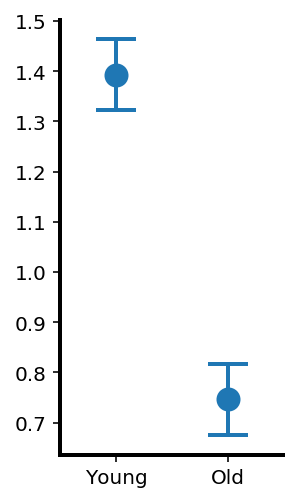

In [25]:
# Plot slope comparison
plot_comp(sls, save_fig=save_fig, save_name='Slopes')

In [26]:
# Statistically test slope difference
print_stat('Slope t-test', *ttest_ind(sls[yng_inds], sls[old_inds]))
print('Mean Difference: \t', np.mean(sls[yng_inds]) - np.mean(sls[old_inds]))

Slope t-test: 	  6.4173 	0.0000
Mean Difference: 	 0.64649270836


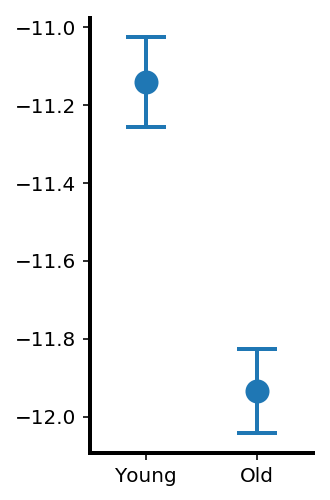

In [27]:
# Plot offset comparison
plot_comp(offs, save_fig=save_fig, save_name='Offset')

In [28]:
# Statistically test offset difference
print_stat('Offset t-test', *ttest_ind(offs[yng_inds], offs[old_inds]))
print('Mean Difference: \t', np.mean(offs[yng_inds]) - np.mean(offs[old_inds]))

Offset t-test: 	  4.9424 	0.0000
Mean Difference: 	 0.791795913651


### Check total alpha power

'Total alpha power', from the FOOOF model, is the model results of the background + the alpha peak amplitude.

In [29]:
# Set the channel to extract alpha power from
ch_ind = 28 # Oz

# Collect the background parameters for each subject
oz_bgs = np.empty(shape=[len(fgs), 2])
for ind, fg in enumerate(fgs):
    oz_bgs[ind, :] = fg.get_all_data('background_params')[ch_ind]

# Calculate total alpha as the value of the BG function at alpha CF, please the amplitude of the alpha peak
tot_alphas = []
for bg, cf, amp in zip(oz_bgs, alphas[:, 0], alphas[:, 1]):

    # If there is no alpha, get the background at CF of 10, and set alpha amplitude to zero
    if np.isnan(cf):
        cf, amp = 10, 0
    
    # Calculate the value of the background function at the alpha-CF, and add the alpha-amp
    tot_alphas.append(expo_nk_function(np.array([cf]), *bg)[0] + amp)
    
tot_alphas = np.array(tot_alphas)

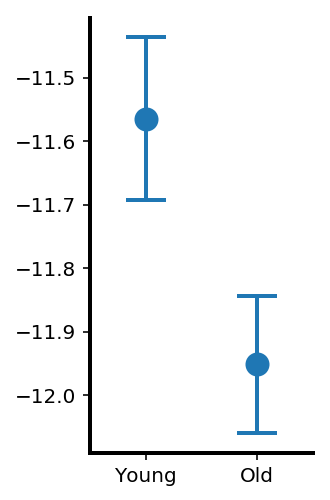

In [30]:
# Plot total alpha - total power values from the FOOOF model at individualzed alpha CFs
#  Note: this is equivalent to doing an individualed alpha frequency analysis, comparing total power
plot_comp(tot_alphas, save_fig=save_fig, save_name='TotalAlpha')

In [31]:
print_stat('Total Alpha t-test', *ttest_ind(tot_alphas[yng_inds], tot_alphas[old_inds]))
print('Mean Difference: \t', np.mean(tot_alphas[yng_inds]) - np.mean(tot_alphas[old_inds]))

Total Alpha t-test: 	  2.2577 	0.0317
Mean Difference: 	 0.386972892497


### Check number of extracted oscillations

In [32]:
ch_ind = 28  # Oz
n_oscs = []
for fg in fgs:
    n_oscs.append(fg.get_results()[ch_ind].peak_params.shape[0])
n_oscs = np.array(n_oscs)

In [33]:
print('# Oscs Yng:', np.mean(n_oscs[yng_inds]))
print('# Oscs Old:', np.mean(n_oscs[old_inds]))
print_stat('\n# Oscs Diff', *ttest_ind(n_oscs[yng_inds], n_oscs[old_inds]))

# Oscs Yng: 4.17647058824
# Oscs Old: 4.28571428571

# Oscs Diff: 	 -0.2742 	0.7858


### Statistically Compare Peak Parameters

In [34]:
for d_ind, label in zip([0, 1, 2], ['CF', 'Amp', 'BW']):

    # Select data
    dat = alphas[:, d_ind]
    you_dat = list(dat[yng_inds][~np.isnan(dat[yng_inds])])# + [0] * sum(np.isnan(dat[yng_inds]))
    old_dat = list(dat[old_inds][~np.isnan(dat[old_inds])])# + [0] * sum(np.isnan(dat[old_inds]))
    
    # Statistically compare and check average difference between groups
    print(label)
    #print('\t', ttest_ind(you_dat, old_dat))
    print_stat('\tDiff', *ttest_ind(you_dat, old_dat))
    print('\tMean Diff: ', np.mean(you_dat - np.mean(old_dat)))
    
# Check how many subjects, 
print('\nNumber of subjects with no alpha:')
print('\t Yng:\t', sum(np.isnan(dat[yng_inds])))
print('\t Old: \t', sum(np.isnan(dat[old_inds])))

CF
	Diff: 	  1.7770 	0.0861
	Mean Diff:  0.937943866588
Amp
	Diff: 	  2.2084 	0.0353
	Mean Diff:  0.293960187817
BW
	Diff: 	  0.3260 	0.7468
	Mean Diff:  0.0931014347813

Number of subjects with no alpha:
	 Yng:	 0
	 Old: 	 0


### Alpha - Center Frequency

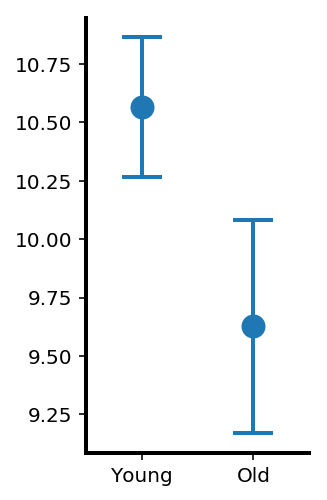

In [35]:
plot_comp(alphas[:, 0], save_fig=save_fig, save_name='AlphaCF')

### Alpha - Amplitude

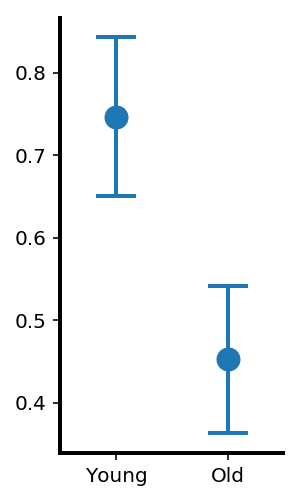

In [36]:
plot_comp(alphas[:, 1], save_fig=save_fig, save_name='AlphaAmp')

### Alpha - Bandwidth

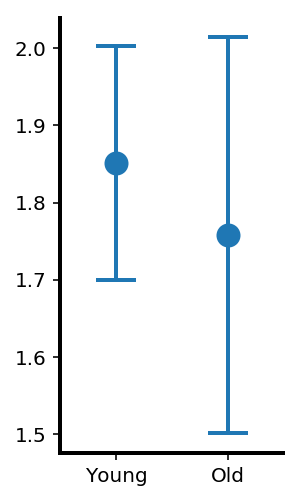

In [37]:
plot_comp(alphas[:, 2], save_fig=save_fig, save_name='AlphaBW')

### Alpha Oscillations - Individual Variation

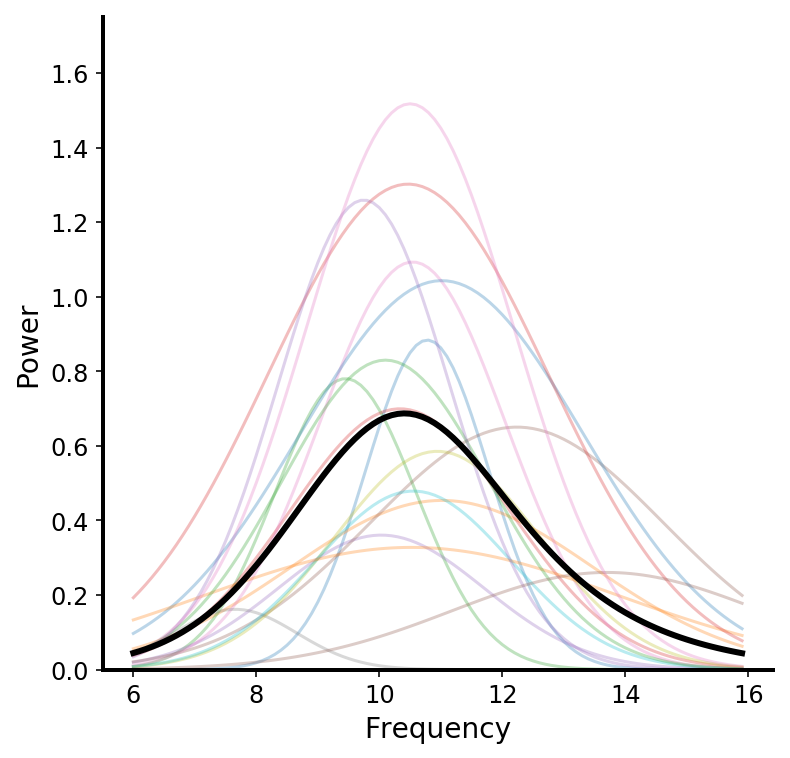

In [38]:
plot_oscillations(alphas[yng_inds, :], save_fig=save_fig, save_name='YoungAlphas')

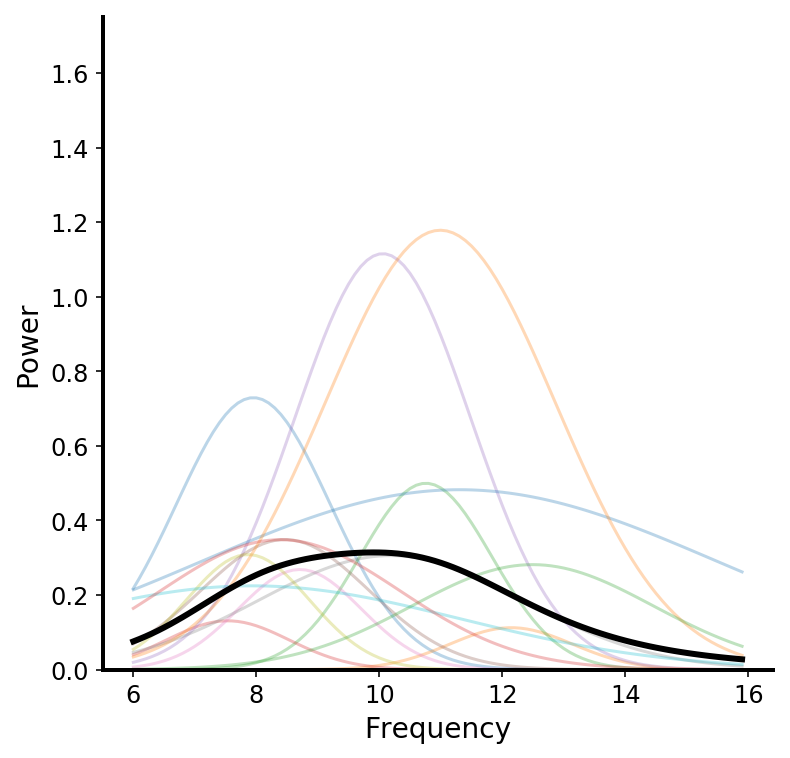

In [39]:
plot_oscillations(alphas[old_inds, :], save_fig=save_fig, save_name='OldAlphas')

### Overlap of Individualized Alpha with Canonical Band

The approach to do this is taken from:

https://stackoverflow.com/questions/32551610/overlapping-probability-of-two-normal-distribution-with-scipy

In [40]:
# Note: current approach presumes no NaNs

overlaps = []
mean, std = 10, 2

for alpha in alphas:
    
    # Get individial CF - keep BW @ 2
    ind_mean, ind_std = alpha[0], 2
    
    if ind_mean <= mean:
        m1, std1, m2, std2 = ind_mean, ind_std, mean, std
    else:
        m1, std1, m2, std2 = mean, std, ind_mean, ind_std
        
    intersect = get_intersect(m1, m2, std1, std2)
    overlaps.append(get_overlap(intersect, m1, m2, std1, std2))
    
overlaps = np.array(overlaps)

In [41]:
# Check average (overall) of overlaps
print('ALL avg overlap: ', np.mean(overlaps), '\n')

# Check average per yng & old group, and test difference
print('YNG avg overlap:', np.mean(overlaps[yng_inds]))
print('OLD avg overlap:', np.mean(overlaps[old_inds]))

print_stat('\nDiff Overlap:', *ttest_ind(overlaps[yng_inds], overlaps[old_inds]))

ALL avg overlap:  0.772093107819 

YNG avg overlap: 0.822273560508
OLD avg overlap: 0.711159700984

Diff Overlap:: 	  1.9155 	0.0653


#### Plot Overlap

Plot for an example case, using the average deviation from 10 Hz. 

In [42]:
# Get the average deviation from center of 10 Hz
avg_deviation = np.mean(np.abs(alphas[:, 0] - 10))

In [43]:
# Compare canonical 10 +/- 2, with a gaussian centered with average deviation
#  Note: in this approach, average deviation shifted below 10 Hz
#    This is arbitrary - still captures deviations above 10 - could be equivalently calculated that way
m1, m2, std1, std2 = 10-avg_deviation, 10, 2, 2
r = get_intersect(m1, m2, std1, std2)

# Check the overlap of the 'average' subject
print(get_overlap(r, m1, m2, std1, std2))

0.765543097899


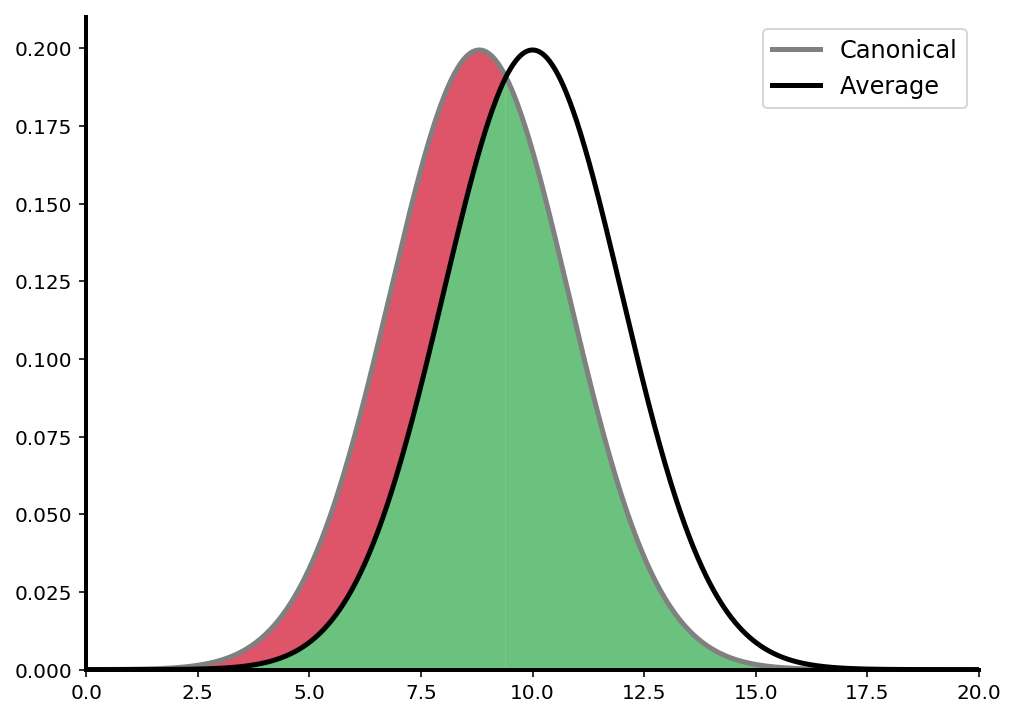

In [44]:
# Plot the overlap of canonical and average shifted alpha
plot_overlap(m1, m2, std1, std2)

#### Compare Slopes

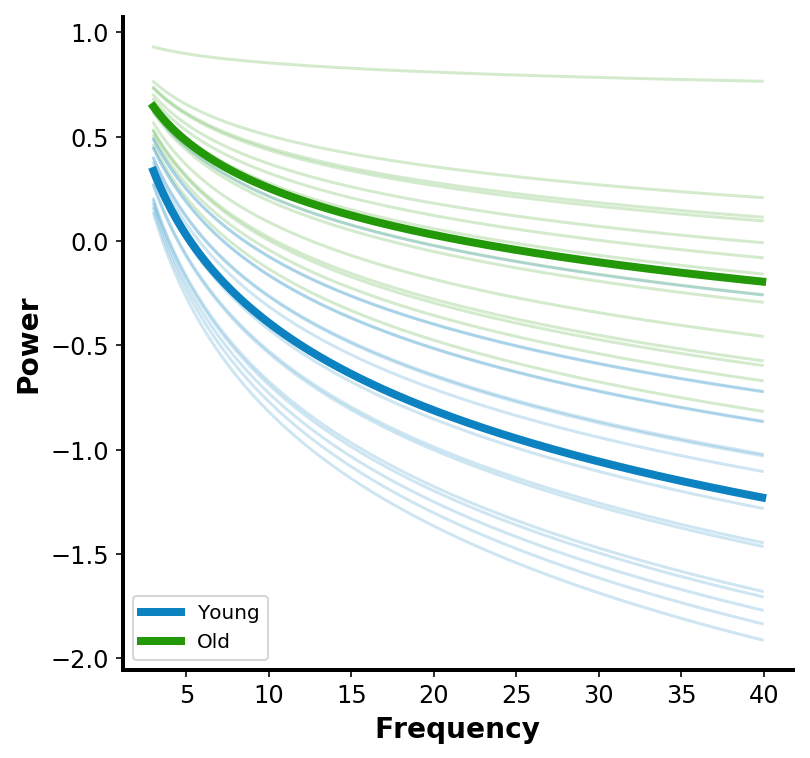

In [45]:
# Plot comparison between groups of just the backgrounds
plot_background(bgs, save_fig=save_fig, save_name='Backgrounds')

### Compare 'Peaks' from Background

Question: compare with just slope, or with slope & offset?

In [46]:
# Pull out the difference in power, at 10 Hz, arising from BG difference
sl_alphas = []
for bg in bgs:
    sl_alphas.append(expo_nk_function(np.array([10]), *bg)[0])
    #sl_alphas.append(expo_nk_function(np.array([10]), 1, bg[1])[0])
    #sl_alphas.append(expo_nk_function(np.array([10]), bg[0], 1)[0])
sl_alphas = np.array(sl_alphas)

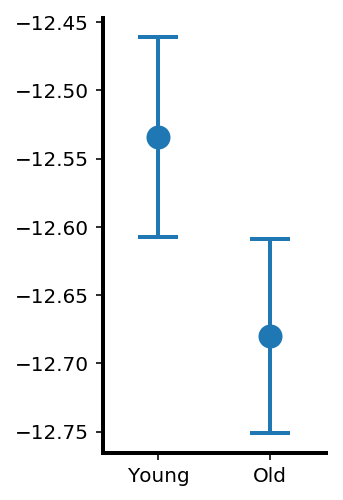

In [47]:
# Compare the 'alpha' difference - coming only from background differences
plot_comp(sl_alphas, save_fig=save_fig, save_name='BGAlpha')

In [48]:
# Statistically test difference in 'BG-Alpha'
ttest_ind(sl_alphas[yng_inds], sl_alphas[old_inds])

Ttest_indResult(statistic=1.4063828769763742, pvalue=0.17023627712641984)

#### Compare across all frequencies

In [49]:
# 
freqs = range(2, 50, 2)
model_bgs = []
for bg in bgs:
    model_bgs.append(expo_nk_function(np.array(freqs), *bg))
    #model_bgs.append(expo_nk_function(np.array(freqs), 0, bg[1]))
    #model_bgs.append(expo_nk_function(np.array(freqs), bg[0], 1))
model_bgs = np.array(model_bgs)

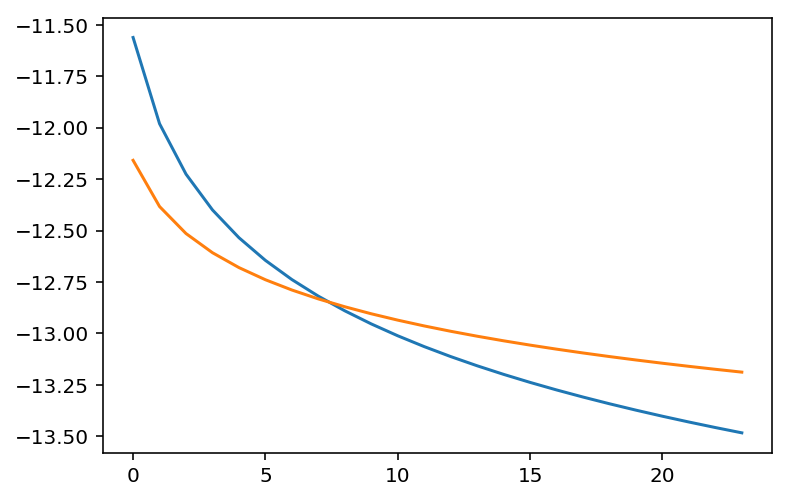

In [50]:
# Plot the difference of the average PSDs between groups (from background alone)
#  Note: a variation on this plot might be more intuitive than the difference plot below
plt.plot(np.mean(model_bgs[yng_inds, :], 0));
plt.plot(np.mean(model_bgs[old_inds, :], 0));

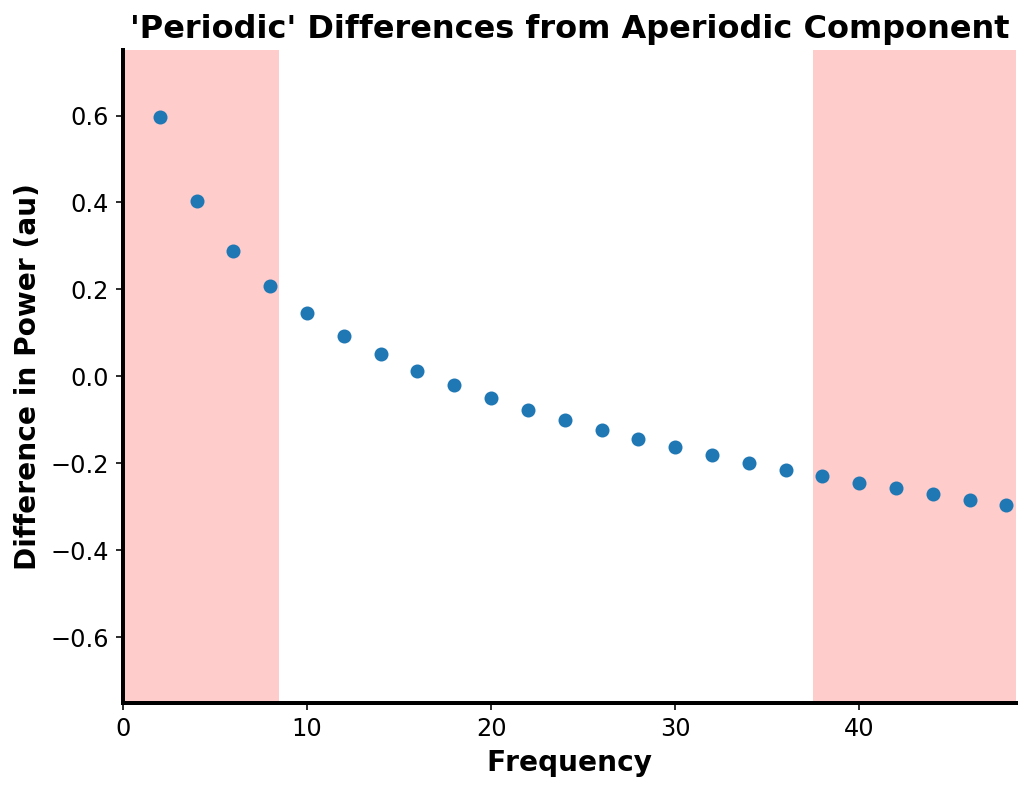

In [51]:
# Plot the comparison of differences at particular frequencies, coming from background
plot_sl_band_diff(freqs, model_bgs)

## Controls - check errors

Check that there isn't a systematic different in model fit error / R^2 that could explain differences

In [52]:
# Extract error & R^2 from FOOOF fits

ch_ind = 28  # Oz

errs = []; r2s = []

for fg in fgs:
    errs.append(fg.get_results()[ch_ind].error)
    r2s.append(fg.get_results()[ch_ind].r_squared)

errs = np.array(errs)
r2s = np.array(r2s)

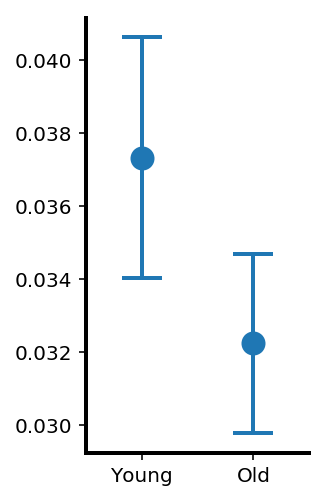

In [53]:
# Compare errors between groups
plot_comp(errs)

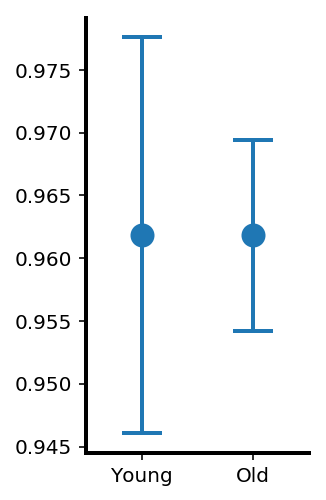

In [54]:
# Compare errors between groups
plot_comp(r2s)

In [55]:
# Statistically compare errors and R^2 between groups
print_stat('Errors', *ttest_ind(errs[yng_inds], errs[old_inds]))
print_stat('R-squared', *ttest_ind(r2s[yng_inds], r2s[old_inds]))

Errors: 	  1.1948 	0.2418
R-squared: 	  0.0008 	0.9993


In [56]:
# Check the correlation between errors and R^2s
print_stat('Errs & R2s ', *pearsonr(errs, r2s))

Errs & R2s : 	 -0.6201 	0.0002


## Correlations between FOOOF Features

In [57]:
# Seperate out Oz BG parameters
oz_offs = oz_bgs[:, 0]; oz_sls = oz_bgs[:, 1]

In [58]:
# Correlation between background features
print_stat('Cz - Off & Sl ', *pearsonr(offs, sls))
print_stat('Oz - Off & Sl ', *pearsonr(oz_offs, oz_sls))

Cz - Off & Sl : 	  0.8868 	0.0000
Oz - Off & Sl : 	  0.8520 	0.0000


In [59]:
# Correlations between oscillation features
print_stat('Osc - Cf  & Amp', *pearsonr(alphas[:, 0], alphas[:, 1]))
print_stat('Osc - Cf  & BW ', *pearsonr(alphas[:, 0], alphas[:, 2]))
print_stat('Osc - Amp & BW ', *pearsonr(alphas[:, 1], alphas[:, 2]))

Osc - Cf  & Amp: 	  0.1657 	0.3730
Osc - Cf  & BW : 	  0.3299 	0.0699
Osc - Amp & BW : 	 -0.0544 	0.7714


In [60]:
# Correlations between slope and oscillation features
print_stat('CF  & Sl ', *pearsonr(alphas[:, 0], oz_sls))
print_stat('Amp & Sl ', *pearsonr(alphas[:, 1], oz_sls))
print_stat('BW  & Sl ', *pearsonr(alphas[:, 2], oz_sls))

CF  & Sl : 	  0.3944 	0.0281
Amp & Sl : 	  0.0915 	0.6245
BW  & Sl : 	  0.4672 	0.0081


In [61]:
# Oz alpha with Cz Slope (?)
print_stat('Oz CF  & Cz Sl', *pearsonr(alphas[:, 0], sls))
print_stat('Oz Amp & Cz Sl', *pearsonr(alphas[:, 1], sls))
print_stat('Oz BW  & Cz Sl', *pearsonr(alphas[:, 2], sls))

Oz CF  & Cz Sl: 	  0.3338 	0.0664
Oz Amp & Cz Sl: 	  0.3650 	0.0435
Oz BW  & Cz Sl: 	  0.3260 	0.0735


In [62]:
# Correlation between FOOOF outputs and error
print_stat('Oz Cf  & Err', *pearsonr(errs, alphas[:, 0]))
print_stat('Oz Amp & Err', *pearsonr(errs, alphas[:, 1]))
print_stat('Oz BW  & Err', *pearsonr(errs, alphas[:, 2]))
print_stat('Oz Sl  & Err', *pearsonr(errs, oz_sls))

Oz Cf  & Err: 	 -0.2017 	0.2766
Oz Amp & Err: 	  0.3339 	0.0664
Oz BW  & Err: 	 -0.2608 	0.1565
Oz Sl  & Err: 	 -0.2105 	0.2556


In [63]:
# Correlation between FOOOF outputs and r2s
print_stat('Oz Cf   & R^2', *pearsonr(r2s, alphas[:, 0]))
print_stat('Oz Amp  & R^2', *pearsonr(r2s, alphas[:, 1]))
print_stat('Oz BW   & R^2', *pearsonr(r2s, alphas[:, 2]))
print_stat('Oz Sl   & R^2', *pearsonr(r2s, oz_sls))

Oz Cf   & R^2: 	  0.3917 	0.0293
Oz Amp  & R^2: 	  0.2822 	0.1241
Oz BW   & R^2: 	  0.3919 	0.0292
Oz Sl   & R^2: 	  0.5332 	0.0020


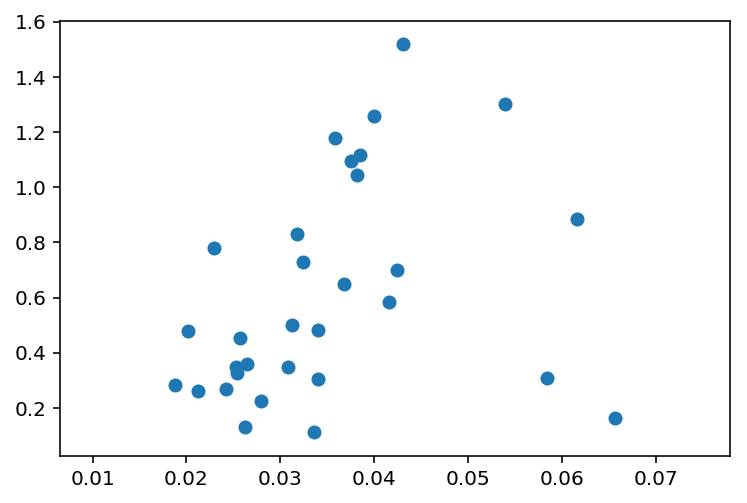

In [64]:
# Scatter plot of inter-measure correlations
plt.scatter(errs, alphas[:, 1])

## Behavioural Correlations With Baseline FOOOF Measures

#### Correlation of Slope With Behaviour

In [65]:
behav_meas = "d'"
#behav_meas = "CDA"
for meas, label in zip([offs, sls, alphas[:, 0], alphas[:, 1], alphas[:, 2]],
                       ['Offset', 'Slope', 'CF', 'Amp', 'BW']):
    
    print('\n'+label)
    print_stat('\tAll', *pearsonr(avg_behav[behav_meas], np.hstack([meas[yng_inds], meas[old_inds]])))
    print_stat('\tYng', *pearsonr(avg_behav[avg_behav['Age'] == 1][behav_meas], meas[yng_inds]))
    print_stat('\tOld', *pearsonr(avg_behav[avg_behav['Age'] == 2][behav_meas], meas[old_inds]))


Offset
	All: 	  0.1284 	0.4914
	Yng: 	 -0.5414 	0.0248
	Old: 	  0.3115 	0.2783

Slope
	All: 	  0.2983 	0.1031
	Yng: 	 -0.3087 	0.2280
	Old: 	  0.4604 	0.0976

CF
	All: 	  0.0854 	0.6480
	Yng: 	 -0.4742 	0.0545
	Old: 	  0.3165 	0.2702

Amp
	All: 	  0.2088 	0.2596
	Yng: 	 -0.2699 	0.2947
	Old: 	  0.5429 	0.0449

BW
	All: 	  0.0449 	0.8104
	Yng: 	 -0.1232 	0.6377
	Old: 	  0.1301 	0.6575


Text(0,0.5,'Slope')

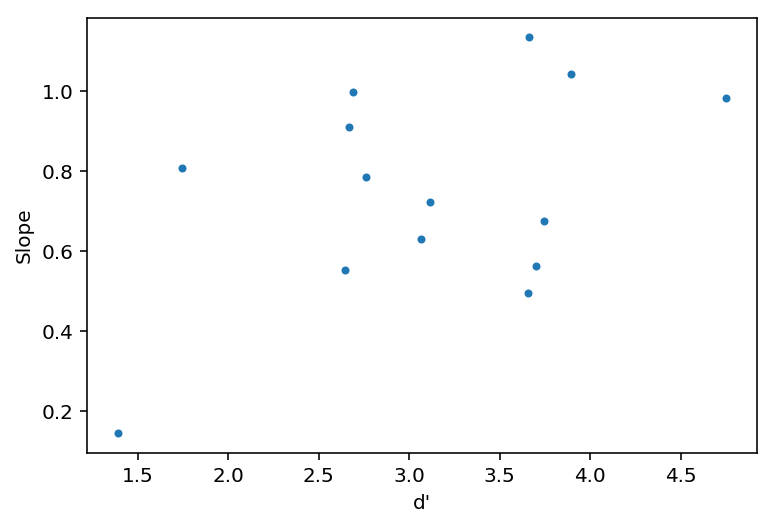

In [66]:
# Plot the correlation between slope and d', in old group
plt.plot(avg_behav[avg_behav['Age'] == 2]["d'"], sls[old_inds], '.')
plt.xlabel("d'")
plt.ylabel("Slope")

## Group FOOOFing - Trial Averaged Data

- Ipsi & Contra

In [67]:
# Settings
#avg_func = np.nanmean
avg_func = np.nanmedian

In [68]:
# Collect measures together from FOOOF results into matrices

all_slopes = np.zeros(shape=[n_loads, n_subjs, n_times])
all_alphas = np.zeros(shape=[n_loads, n_subjs, n_times])

#side = 'Contra'
side = 'Ipsi'

for li, load in enumerate(['Load1', 'Load2', 'Load3']):
    
    # Load the FOOOF analyses of the average
    pre, early, late = FOOOFGroup(), FOOOFGroup(), FOOOFGroup()
    pre.load('Group_' + load + '_' + side + '_Pre', pjoin(res_path, 'FOOOF'))
    early.load('Group_' + load + '_' + side +  '_Early', pjoin(res_path, 'FOOOF'))
    late.load('Group_' + load + '_' + side + '_Late', pjoin(res_path, 'FOOOF'))

    for ind, fg in enumerate([pre, early, late]):
        all_slopes[li, :, ind] = fg.get_all_data('background_params', 'slope').T
        all_alphas[li, :, ind] = get_band_peak_group(fg.get_all_data('peak_params'), [7, 14], len(fg))[:, 1]
        
# Replace alpha NaN's with 0
all_alphas[np.isnan(all_alphas)] = 0

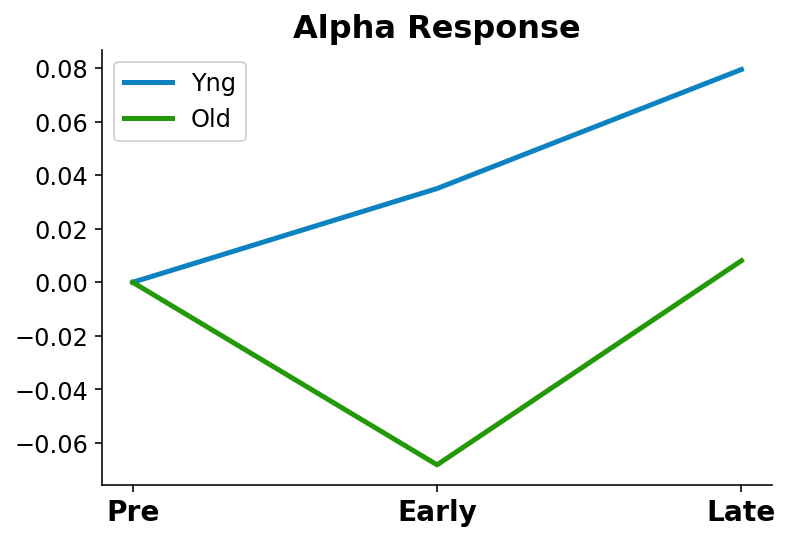

In [69]:
# Plot Alpha response, split up by group, collapsed across load
plot_task_response(all_alphas, 'Alpha')#, save_fig=save_fig, save_name='AlphaResponse')

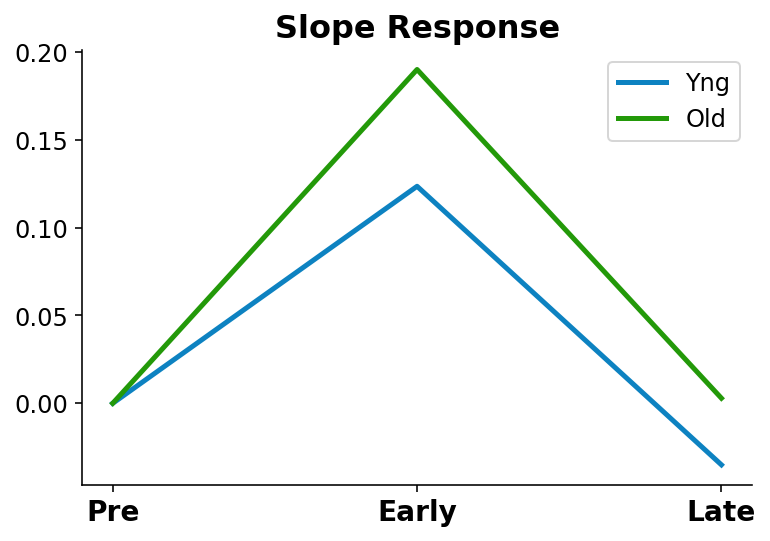

In [70]:
# Plot Slope response, split up by group, collapsed across load
plot_task_response(all_slopes, 'Slope')#, save_fig=save_fig, save_name='SlopeResponse')

In [71]:
# Partition group
subset = 'old' # 'all', 'yng', 'old'

if subset == 'old': 
    s_inds = old_inds
if subset == 'yng':
    s_inds = yng_inds
if subset == 'all':
    s_inds = range(0, 31)

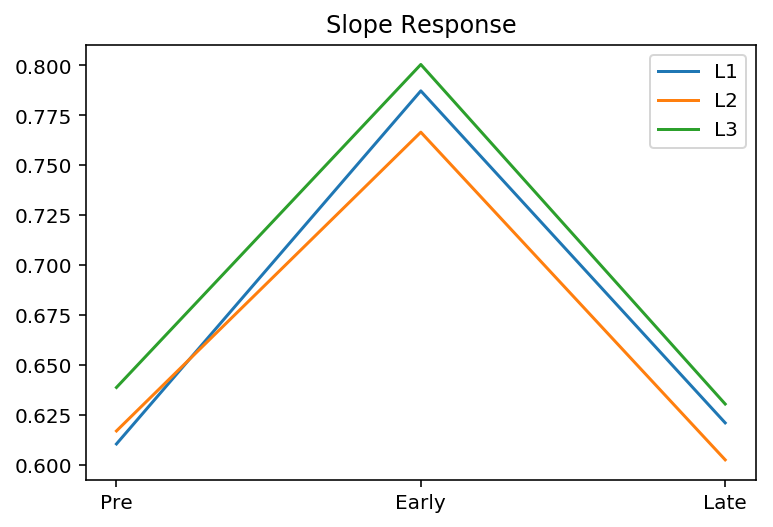

In [72]:
# Plot slope average response - split up by load
plt.figure()
for l_ind in range(3):
    plt.plot(avg_func(all_slopes[l_ind, s_inds, :], 0), label='L' + str(l_ind + 1))
plt.title('Slope Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
plt.legend();

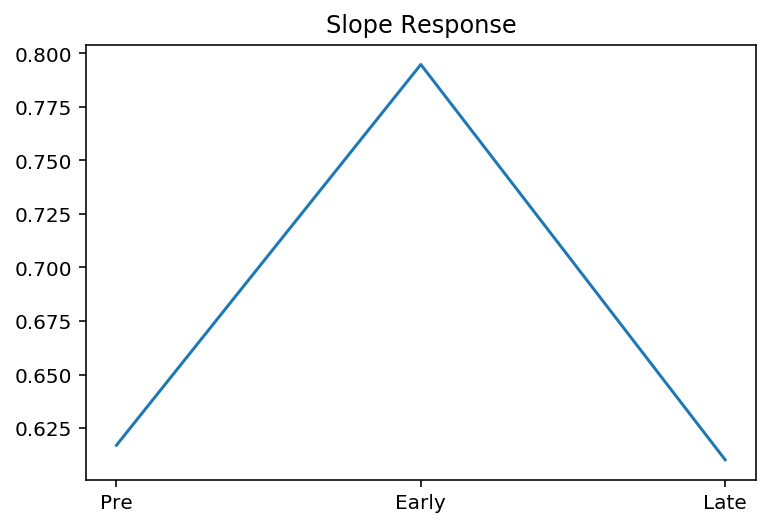

In [73]:
# Plot slope average response - collapsed across loads
plt.figure()
plt.plot(avg_func(avg_func(all_slopes[:, s_inds, :], 0), 0))
plt.title('Slope Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
#plt.legend();

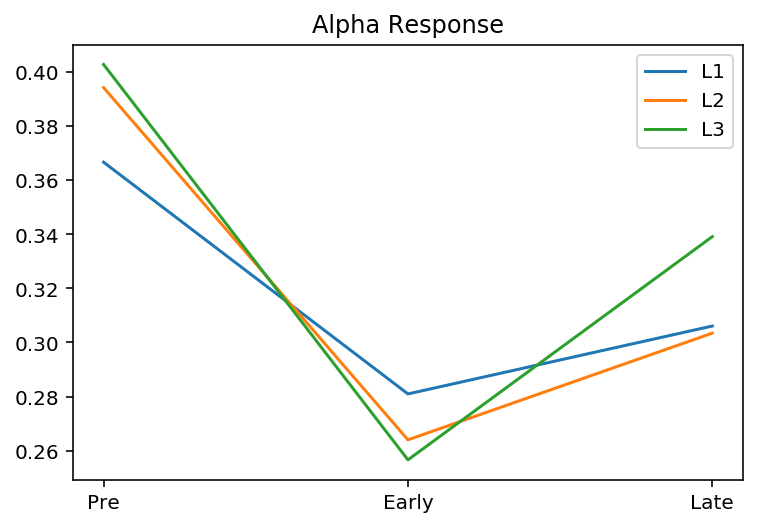

In [74]:
# Plot alpha average response - split up by load
plt.figure()
for l_ind in range(3):
    plt.plot(avg_func(all_alphas[l_ind, s_inds, :], 0), label='L' + str(l_ind + 1))
plt.title('Alpha Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
plt.legend();

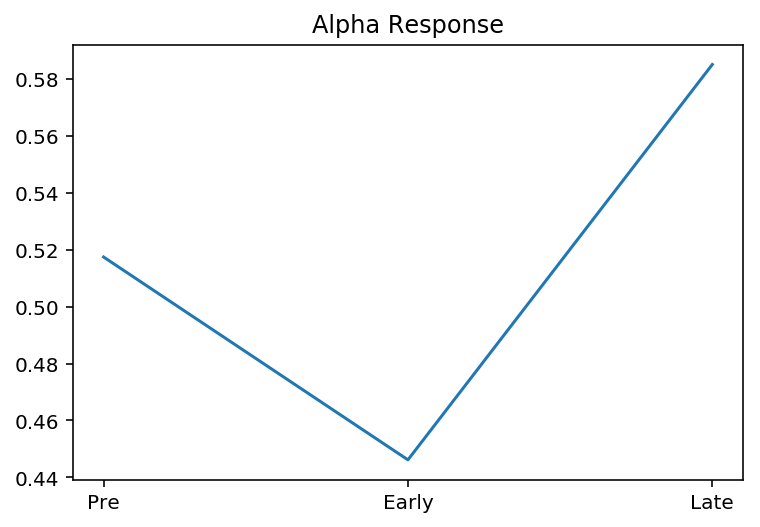

In [75]:
# Plot alpha average response - collapsed across loads
plt.figure()
plt.plot(avg_func(avg_func(all_alphas, 0), 0))
plt.title('Alpha Response')
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);

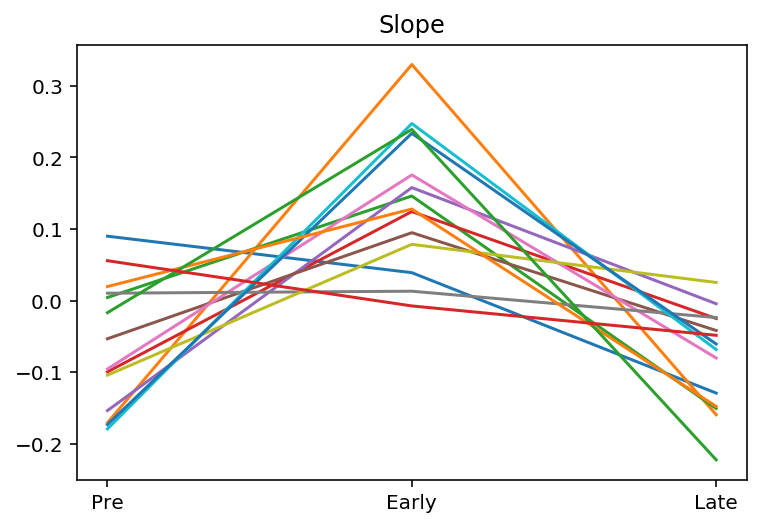

In [76]:
plt.figure()
for dat in all_slopes[2, s_inds, :]:
    #plt.plot(dat)
    plt.plot(dat - np.mean(dat))
plt.xticks([0, 1, 2], ['Pre', 'Early', 'Late']);
plt.title('Slope');

In [77]:
# Check the correlation between alpha & slope responses
pearsonr(all_alphas[0, :, 1] - all_alphas[0, :, 0], all_slopes[0, :, 1] - all_slopes[0, :, 0])

(-0.43984166030482941, 0.013287372744740083)

## Check Behaviour & Trial EPhys Corrs

- Baseline measures
- Task related 'reactivity' measures

Note: all_slopes & all_alphas have shape of [n_loads, n_subjs, n_times]

In [78]:
import pandas as pd

import patsy
import statsmodels.api as sm

/Users/tom/anaconda/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [79]:
# Predict behaviour from 'absolute' FOOOF trial output measures

# Settings
t_ind = 0

# Build the dataframe
df = pd.DataFrame()
df['slope'] = all_slopes[:, :, t_ind].flatten()
df['alpha'] = all_alphas[:, :, t_ind].flatten()
df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values

# Specift the model
#outcome, predictors = patsy.dmatrices("behav ~ slope + alpha + age", df)
outcome, predictors = patsy.dmatrices("behav ~ slope * alpha * age", df)
#outcome, predictors = patsy.dmatrices("behav ~ age + alpha + slope + alpha:age + slope:age", df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Check out the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.236
Model:                            OLS   Adj. R-squared:                  0.173
Method:                 Least Squares   F-statistic:                     3.745
Date:                Mon, 30 Jul 2018   Prob (F-statistic):            0.00139
Time:                        23:27:36   Log-Likelihood:                -117.84
No. Observations:                  93   AIC:                             251.7
Df Residuals:                      85   BIC:                             271.9
Df Model:                           7                                         
Covariance Type:            nonrobust                                         
                      coef    std err          t      P>|t|      [0.025      0.975]
-----------------------------------------------------------------------------------
Intercept           9.8885      2.438     

In [80]:
# Predict from absolute FOOOF results, split up by group

# Settings
group = 'young' # 'young', 'old'
t_ind = 2

inds = yng_inds if 'young' else old_inds
age_gr = 1 if 'young' else 2

# Build the dataframe
df = pd.DataFrame()
df['slope'] = all_slopes[:, inds, t_ind].flatten()
df['alpha'] = all_alphas[:, inds, t_ind].flatten()
df['behav'] = behav_dat[behav_dat.Age == age_gr]["d'"].values

# 
outcome, predictors = patsy.dmatrices("behav ~ slope + alpha", df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Check out the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.035
Model:                            OLS   Adj. R-squared:                 -0.005
Method:                 Least Squares   F-statistic:                    0.8759
Date:                Mon, 30 Jul 2018   Prob (F-statistic):              0.423
Time:                        23:27:36   Log-Likelihood:                -64.309
No. Observations:                  51   AIC:                             134.6
Df Residuals:                      48   BIC:                             140.4
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3780      0.510      8.587      0.0

In [81]:
# Check relation between slope and alpha
#print(pearsonr(df.sl, df.al))
#plt.plot(df.sl, df.al, '.')

#print(pearsonr(df.beh, df.al))
#plt.plot(df.beh, df.al, '.')

#print(pearsonr(df.beh, df.sl))
#plt.plot(df.beh, df.sl, '.')

In [82]:
l_ind = 0
t_ind = 0

print_stat("Sl-Lo-d'", *pearsonr(all_slopes[l_ind, :, t_ind], behav_dat[behav_dat.Load == l_ind + 1]["d'"]))
print_stat("Al-Lo-d'", *pearsonr(all_alphas[l_ind, :, t_ind], behav_dat[behav_dat.Load == l_ind + 1]["d'"]))

Sl-Lo-d': 	 -0.1952 	0.2928
Al-Lo-d': 	 -0.2468 	0.1807


In [83]:
t_ind = 2

print_stat("Sl-d'", *pearsonr(all_slopes[:, :, t_ind].flatten(), behav_dat["d'"].values))
print_stat("Al-d'", *pearsonr(all_alphas[:, :, t_ind].flatten(), behav_dat["d'"].values))

Sl-d': 	 -0.2772 	0.0071
Al-d': 	 -0.2689 	0.0091


In [84]:
# Average d' with average measures
print_stat('XX', *pearsonr(avg_behav["d'"], np.mean(all_slopes[:, :, 2], 0)))
print_stat('XX', *pearsonr(avg_behav["d'"], np.mean(all_alphas[:, :, 2], 0)))

XX: 	 -0.3296 	0.0702
XX: 	 -0.2940 	0.1084


In [85]:
#
sl_st_yng = np.vstack([all_slopes[0, yng_inds, :], all_slopes[1, yng_inds, :], all_slopes[2, yng_inds, :]])
sl_st_old = np.vstack([all_slopes[0, old_inds, :], all_slopes[1, old_inds, :], all_slopes[2, old_inds, :]])

#
al_st_yng = np.vstack([all_alphas[0, yng_inds, :], all_alphas[1, yng_inds, :], all_alphas[2, yng_inds, :]])
al_st_old = np.vstack([all_alphas[0, old_inds, :], all_alphas[1, old_inds, :], all_alphas[2, old_inds, :]])

In [86]:
ind = 2

print_stat('Yng-Sl', *pearsonr(sl_st_yng[:, ind], behav_dat[behav_dat.Age == 1]["d'"]))
print_stat('Old-Sl', *pearsonr(sl_st_old[:, ind], behav_dat[behav_dat.Age == 2]["d'"]))

print('')

print_stat('Yng-Al', *pearsonr(al_st_yng[:, ind], behav_dat[behav_dat.Age == 1]["d'"]))
print_stat('Old-Al', *pearsonr(al_st_old[:, ind], behav_dat[behav_dat.Age == 2]["d'"]))

Yng-Sl: 	 -0.1633 	0.2522
Old-Sl: 	  0.0152 	0.9238

Yng-Al: 	 -0.1063 	0.4576
Old-Al: 	  0.3360 	0.0296


In [87]:
sl_dif_yng = sl_st_yng[:, 2] - sl_st_yng[:, 1]
print_stat('Sl-Yng', *pearsonr(sl_dif_yng, behav_dat[behav_dat.Age == 1]["d'"]))
sl_dif_old = sl_st_old[:, 2] - sl_st_old[:, 1]
print_stat('Sl-Old', *pearsonr(sl_dif_old, behav_dat[behav_dat.Age == 2]["d'"]))

print('')

al_dif_yng = al_st_yng[:, 2] - al_st_yng[:, 1]
print_stat('Al-Yng', *pearsonr(al_dif_yng, behav_dat[behav_dat.Age == 1]["d'"]))
al_dif_old = al_st_old[:, 2] - al_st_old[:, 1]
print_stat('Al-Old', *pearsonr(al_dif_old, behav_dat[behav_dat.Age == 2]["d'"]))

Sl-Yng: 	  0.2219 	0.1176
Sl-Old: 	 -0.2131 	0.1754

Al-Yng: 	 -0.4214 	0.0021
Al-Old: 	  0.2726 	0.0808


In [88]:
sl_dif_yng = sl_st_yng[:, 2] - sl_st_yng[:, 0]
print_stat('Sl-Yng', *pearsonr(sl_dif_yng, behav_dat[behav_dat.Age == 1]["d'"]))
sl_dif_old = sl_st_old[:, 2] - sl_st_old[:, 0]
print_stat('Sl-Old', *pearsonr(sl_dif_old, behav_dat[behav_dat.Age == 2]["d'"]))

print('')

al_dif_yng = al_st_yng[:, 2] - al_st_yng[:, 0]
print_stat('Al-Yng', *pearsonr(al_dif_yng, behav_dat[behav_dat.Age == 1]["d'"]))
al_dif_old = al_st_old[:, 2] - al_st_old[:, 0]
print_stat('Al-Old', *pearsonr(al_dif_old, behav_dat[behav_dat.Age == 2]["d'"]))

Sl-Yng: 	  0.3795 	0.0060
Sl-Old: 	 -0.0793 	0.6174

Al-Yng: 	 -0.1563 	0.2734
Al-Old: 	  0.3744 	0.0146


In [89]:
# Build the dataframe

t_ind = 2

df = pd.DataFrame()

df['behav'] = behav_dat["d'"].values
df['age'] = behav_dat['Age'].values


df['sl_dif'] = np.concatenate([sl_dif_yng, sl_dif_old])
df['al_dif'] = np.concatenate([al_dif_yng, al_dif_old])

# 
outcome, predictors = patsy.dmatrices("behav ~ sl_dif + al_dif + age", df)
#outcome, predictors = patsy.dmatrices("behav ~ age * sl_dif * al_dif", df)
mod = sm.OLS(outcome, predictors)
res = mod.fit()

# Check out the results
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:                  behav   R-squared:                       0.157
Model:                            OLS   Adj. R-squared:                  0.129
Method:                 Least Squares   F-statistic:                     5.531
Date:                Mon, 30 Jul 2018   Prob (F-statistic):            0.00158
Time:                        23:27:37   Log-Likelihood:                -122.39
No. Observations:                  93   AIC:                             252.8
Df Residuals:                      89   BIC:                             262.9
Df Model:                           3                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept      4.3526      0.317     13.732      0.0

In [90]:
print(pearsonr(sl_dif_yng, al_dif_yng))
print(pearsonr(sl_dif_old, al_dif_old))

(-0.2176059812806159, 0.12504481107033472)
(-0.26513266284915271, 0.089711660612480773)


In [91]:
# Average across loads
sl_resps = np.diff(np.mean(all_slopes, 0))
al_resps = np.diff(np.mean(all_alphas, 0))

# # Take specific load
# load_ind = 2
# sl_resps = all_slopes[load_ind, :, :]
# al_resps = all_alphas[load_ind, :, :]

In [92]:
# Correlations between reactivity measures
print_stat('SLR & ALR - 1', *pearsonr(sl_resps[:, 0], al_resps[:, 0]))
print_stat('SLR & ALR - 2', *pearsonr(sl_resps[:, 1], al_resps[:, 1]))

SLR & ALR - 1: 	 -0.4753 	0.0069
SLR & ALR - 2: 	 -0.4776 	0.0066


In [93]:
edat = sl_resps; ind = 0;

print_stat('\tALL', *pearsonr(avg_behav["d'"], al_resps[:, 0]))
print_stat('\tYNG', *pearsonr(avg_behav[avg_behav['Age'] == 1]["d'"], edat[yng_inds, ind]))
print_stat('\tOLD', *pearsonr(avg_behav[avg_behav['Age'] == 2]["d'"], edat[old_inds, ind]))

	ALL: 	 -0.0476 	0.7992
	YNG: 	  0.1230 	0.6382
	OLD: 	  0.2406 	0.4073


In [94]:
edat = sl_resps

print_stat('\tALL', *pearsonr(avg_behav["d'"], al_resps[:, 0]))
print_stat('\tYNG', *pearsonr(avg_behav[avg_behav['Age'] == 1]["d'"], np.mean(edat[yng_inds], 1)))
print_stat('\tOLD', *pearsonr(avg_behav[avg_behav['Age'] == 2]["d'"], np.mean(edat[old_inds], 1)))

	ALL: 	 -0.0476 	0.7992
	YNG: 	  0.5637 	0.0184
	OLD: 	 -0.1164 	0.6919


In [95]:
print(pearsonr(avg_behav["CDA"], al_resps[:, 0]))
print(pearsonr(avg_behav["CDA"], sl_resps[:, 0]))

(0.36179408309024969, 0.045507397669268028)
(-0.2990281210724145, 0.10223014390773394)
